# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [26]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



DESCARGAR HTML

In [27]:
url = "https://ycharts.com/companies/TSLA/revenues"

# Intentar primera solicitud con un agente de usuario estándar
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"
}
response = requests.get(url, headers=headers)
time.sleep(10)  # Espera opcional de 10 segundos antes de la siguiente solicitud

# Verificar si la solicitud inicial fue bloqueada
if response.status_code == 403:
    # Si se bloquea, intentar nuevamente con un agente de usuario diferente
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    time.sleep(10)  # Espera opcional de 10 segundos antes de la siguiente solicitud

# Extraer el HTML de la respuesta final
html_data = response.text

# Imprimir o manejar el HTML según sea necesario
print(html_data)










<!doctype html>
<html lang="en" ng-jq>
    <head>
        <title>
        Tesla Revenue (Quarterly) Analysis | YCharts
        </title>

        <meta name="viewport" content="width=device-width, initial-scale=1.0" />
<!-- This code allows us to correctly display the page on mobile devices -->
<script defer>
    var viewport = document.querySelector('meta[name=viewport]');
    if (viewport) {
        var minWidth = 700;
        if (screen.width < minWidth) {
            document.head.removeChild(viewport);
            var newViewport = document.createElement('meta');
            newViewport.setAttribute('name', 'viewport');
            newViewport.setAttribute('content', 'width=' + minWidth);
            document.head.appendChild(newViewport);
        }
    }
</script>


        
        <script>
    if (navigator.userAgent.indexOf('Trident') !== -1 || navigator.userAgent.indexOf('MSIE') !== -1) {
        window.onload=function() {
            var ie_banner = document.createEle

TRANSFORMAR EL HTML

1# BUSCAR TODAS LAS TABLAS

In [76]:
# Crea un objeto BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')
# Busca todas las tablas en el HTML
tables = soup.find_all('table')

# Imprime la cantidad de tablas encontradas
print(f'Se encontraron {len(tables)} tablas en la página.')


Se encontraron 4 tablas en la página.


2# ENCONTRAR TABLA EVOLUCION TRIMESTRAL

In [77]:
table=tables[0]
table

<table class="table">
<thead>
<tr>
<th>Date</th>
<th class="text-right">Value</th>
</tr>
</thead>
<tbody>
<tr>
<td>March 31, 2024</td>
<td class="text-right">
                            
                                21.30B
                            
                        </td>
</tr>
<tr>
<td>December 31, 2023</td>
<td class="text-right">
                            
                                25.17B
                            
                        </td>
</tr>
<tr>
<td>September 30, 2023</td>
<td class="text-right">
                            
                                23.35B
                            
                        </td>
</tr>
<tr>
<td>June 30, 2023</td>
<td class="text-right">
                            
                                24.93B
                            
                        </td>
</tr>
<tr>
<td>March 31, 2023</td>
<td class="text-right">
                            
                                23.33B
                       

3# y #4 ALMACENA LOS DATOS EN UN DATAFRAME y PROCESA DATAFRAME

In [128]:
tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in table.tbody.find_all("tr"):
    col = row.find_all("td")
    if col!=[]:
        date = col[0].text
        revenue = col[1].text.replace("\n","").replace(" ","").replace("B","")
        revenueF = float (revenue)
        hu = tesla_revenue.loc[len(tesla_revenue)] = (date, revenueF)
print(tesla_revenue)


        
        
        


                  Date  Revenue
0       March 31, 2024   21.300
1    December 31, 2023   25.170
2   September 30, 2023   23.350
3        June 30, 2023   24.930
4       March 31, 2023   23.330
5    December 31, 2022   24.320
6   September 30, 2022   21.450
7        June 30, 2022   16.930
8       March 31, 2022   18.760
9    December 31, 2021   17.720
10  September 30, 2021   13.760
11       June 30, 2021   11.960
12      March 31, 2021   10.390
13   December 31, 2020   10.740
14  September 30, 2020    8.771
15       June 30, 2020    6.036
16      March 31, 2020    5.985
17   December 31, 2019    7.384
18  September 30, 2019    6.303
19       June 30, 2019    6.350
20      March 31, 2019    4.541
21   December 31, 2018    7.226
22  September 30, 2018    6.824
23       June 30, 2018    4.002
24      March 31, 2018    3.409


#5 ALMACENAR DATOS EN SQLITE

In [116]:
import sqlite3

conexion=sqlite3.connect("Tesla.db")
cursor = conexion.cursor()
try:
    conexion.execute("""create table data_tesla (Date,Revenue,codigo integer primary key AUTOINCREMENT)""")
except sqlite3.OperationalError:
    print("La tabla ya existe")
for index,row in tesla_revenue.iterrows():
    cursor.execute("Insert into data_tesla (Date, Revenue) values(?,?)",(row.Date, row.Revenue))
conexion.commit()
cursor.close()


La tabla ya existe


#6 VISUALIZA LOS DATOS

### Visualización de series de tiempo

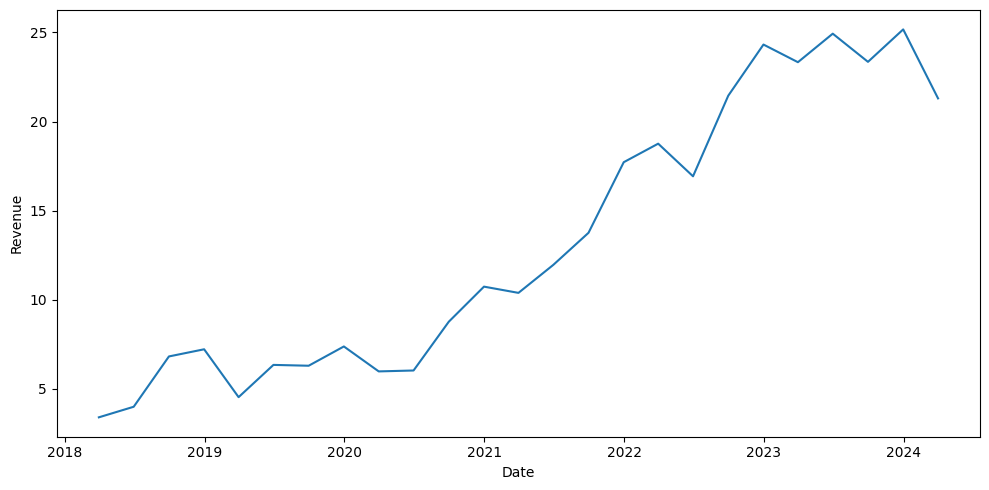

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"]

sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

### Beneficio bruto anual

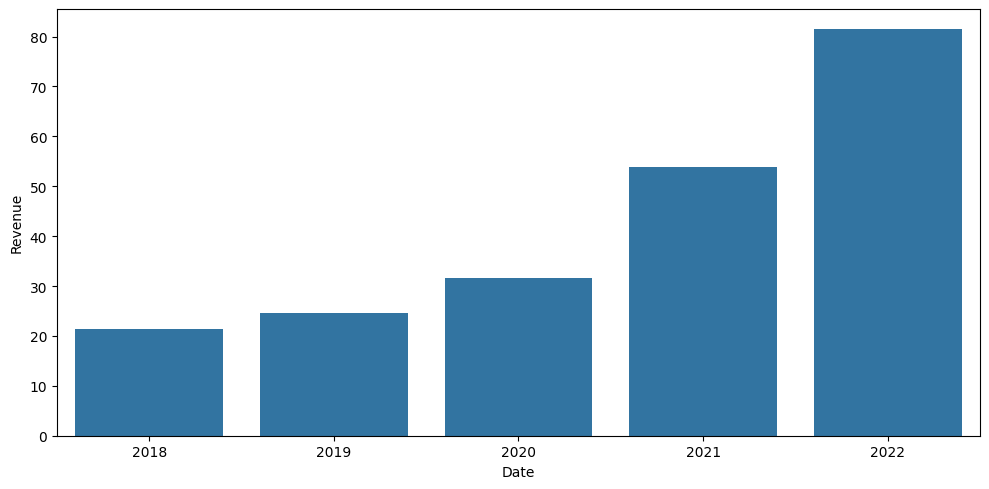

In [144]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year)["Revenue"].sum().reset_index()
tesla_revenue_yearly = tesla_revenue_yearly[tesla_revenue_yearly["Date"] < 2023]

sns.barplot(data=tesla_revenue_yearly, x="Date", y="Revenue", ax=axis)

plt.tight_layout()

plt.show()


### Beneficio bruto mensual

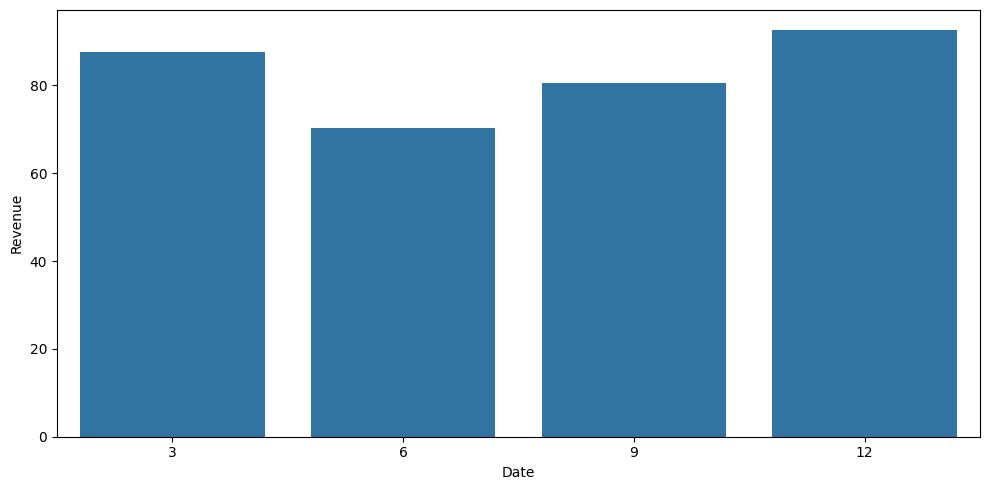

In [146]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue_monthly = tesla_revenue.groupby(tesla_revenue["Date"].dt.month)["Revenue"].sum().reset_index()

sns.barplot(data = tesla_revenue_monthly, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()